# 使用卷积网络分类心电信号

之前想的是将信号处理之后再训练，按照RR周期的大小截取心电得到每个样本的长度都不一致，后续的处理没想到很好的解决办法。看到有的文献直接将滤波后的信号丢到神经网络中训练，这里想着先尝试着试一下把滤波的信号放进神经网络训练，如果不行，再试着放入原始的心电信号。这里唯一的处理就是对样本不平衡的处理

In [1]:
# import main modules
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("torch version:", torch.__version__)
print("device:", device)

torch version: 1.9.0+cu102
device: cuda


## 读取数据集

In [2]:
data_filepath = "../data/numpy_data/"

X_train = np.load(data_filepath + 'X_train.npy')
y_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
X_test = np.load(data_filepath + 'X_test.npy')
y_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)


In [3]:
y_train

array([[list(['NORM'])],
       [list(['NORM'])],
       [list(['NORM'])],
       ...,
       [list(['STTC'])],
       [list(['NORM'])],
       [list(['NORM'])]], dtype=object)

### 将y映射为数组

In [4]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

In [5]:
# 类别映射函数
def label2num(labels):
    for index in range(len(labels)):
        labels[index] = np.where(num2class == labels[index][0][0])[0]

In [6]:
label2num(y_train)
label2num(y_test)

y_train = y_train.flatten().astype(np.int)
y_test = y_test.flatten().astype(np.int)

In [7]:
y_train

array([0, 0, 0, ..., 2, 0, 0])

绘图查看十二导联心电样本

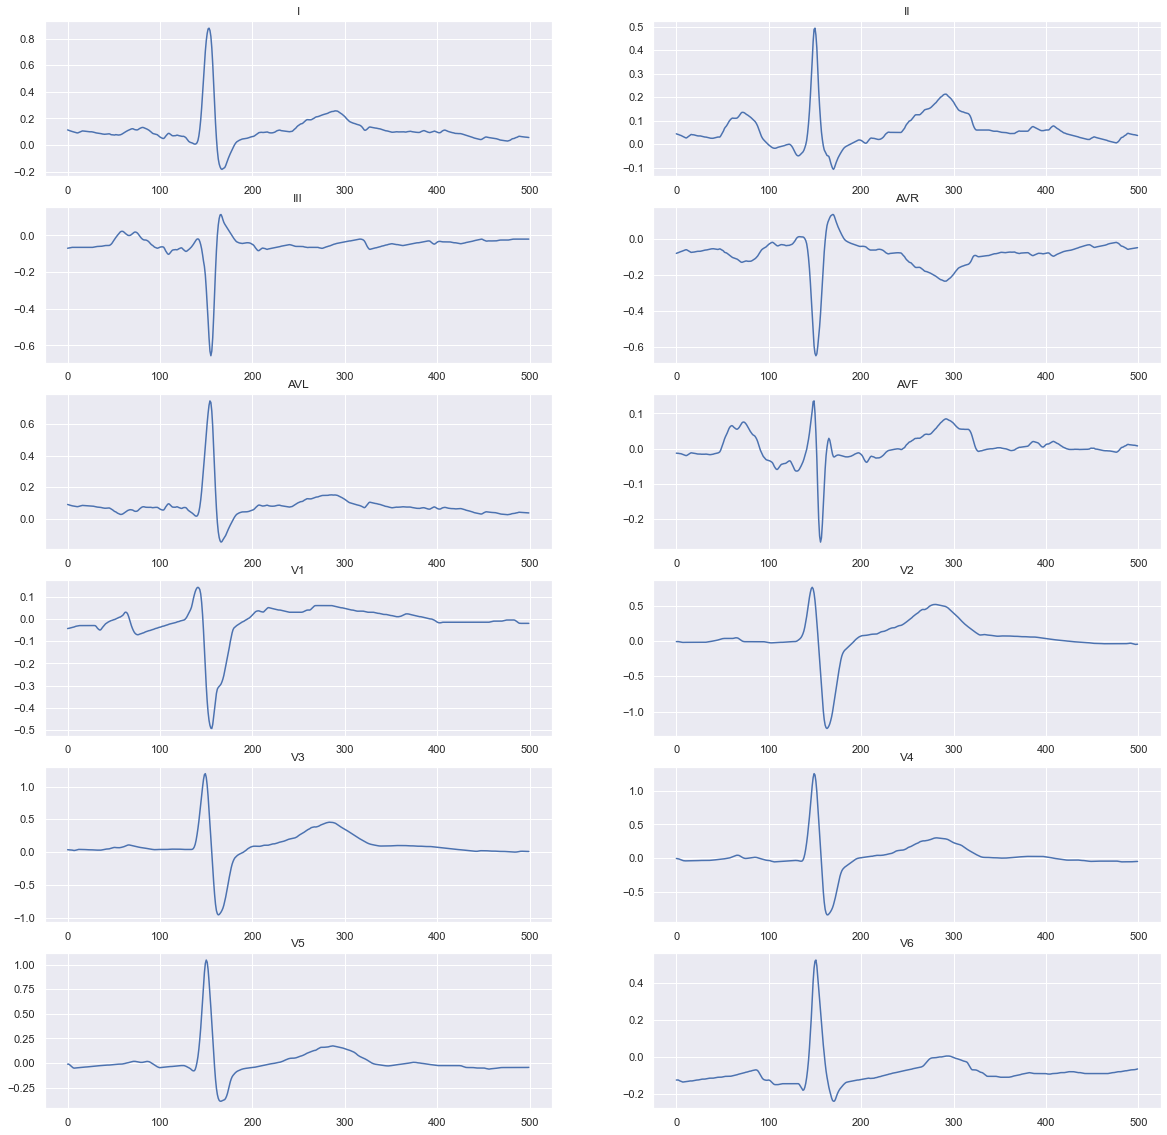

In [8]:
plt.figure(figsize=(20,20))
signame = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(X_train[1000][:,i])
    plt.title(signame[i])
plt.show()

In [9]:
X_train.shape

(16966, 500, 12)

In [10]:
# 生成数据集
batch_size = 64

# 转换x的维度
X_train = X_train.reshape(X_train.shape[0], 1, 500, 12)
X_test = X_test.reshape(X_test.shape[0], 1, 500, 12)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

## 定义ResNet神经网络

In [11]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，我们使用基本的Block
    基础块没有维度压缩，所以expansion=1
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [12]:
# 测试
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 500, 12)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 500, 12])


In [13]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [14]:
# 测试
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


In [15]:
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=(31, 2))
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [16]:
def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

In [17]:
net = ResNet34().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [18]:
# 测试整个神经网络输入输出形状
x = torch.randn(2, 1, 500, 12).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 5])


## Train model

In [19]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [20]:
# training function
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = torch.Tensor([0.0]).float().to(device)
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss.item(), 100.*correct/total, correct, total))
    return train_loss

In [21]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [22]:
for epoch in range(start_epoch, 100):
    loss = train(epoch)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss)


Epoch: 0
[1,   100] loss: 184.349686 |  Acc: 44.047% (2819/6400)
[1,   200] loss: 325.300842 |  Acc: 45.688% (5848/12800)
Total loss: 416.274567

Epoch: 1
[2,   100] loss: 134.323456 |  Acc: 50.141% (3209/6400)
[2,   200] loss: 269.908234 |  Acc: 49.586% (6347/12800)
Total loss: 356.612061

Epoch: 2
[3,   100] loss: 131.652283 |  Acc: 51.141% (3273/6400)
[3,   200] loss: 254.648605 |  Acc: 52.617% (6735/12800)
Total loss: 335.135956

Epoch: 3
[4,   100] loss: 119.114471 |  Acc: 55.594% (3558/6400)
[4,   200] loss: 232.766373 |  Acc: 56.617% (7247/12800)
Total loss: 306.592407

Epoch: 4
[5,   100] loss: 111.370758 |  Acc: 58.547% (3747/6400)
[5,   200] loss: 218.074341 |  Acc: 59.547% (7622/12800)
Total loss: 287.191467

Epoch: 5
[6,   100] loss: 101.358978 |  Acc: 62.328% (3989/6400)
[6,   200] loss: 201.392639 |  Acc: 62.508% (8001/12800)
Total loss: 266.515564

Epoch: 6
[7,   100] loss: 96.702614 |  Acc: 64.219% (4110/6400)
[7,   200] loss: 190.575348 |  Acc: 64.750% (8288/12800)
To